# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Alpha](#Alpha)
* [Discussion](#Discussion)

# Introduction

This is a post hoc tuning after seeing disappointing holdout results. We dropped ridge earlier for simplicity and speed, but now it's back in.

Since I'm close to wrapping up at this point, we'll do a quick tune and won't stop to evaluate too much.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 8.78 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = (
    "../24.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_song_data"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "./tune_ridge"

_ = gc_collect()

time: 143 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather("./scaled_features_ready_for_selection.feather").set_index(
        "id"
    )
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 303 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 41 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           85740 non-null  float64
 1   LDA2                                                                           85740 non-null  float64
 2   ocLDA_neg                                                                      85740 non-null  float64
 3   ocLDA_neu                                                                      85740 non-null  float64
 4   ocLDA_pos                                                                      85740 non-null  float64
 5   ocSVM_sgdlinear_LDA1                                                           85740 non-null  float64
 6   ocSVM_sgdlinear_LDA2 

# Strata

In [7]:
N_SPLITS = 8

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Dask Apply: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


time: 12.7 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 220 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 52
only 2: 37
only 3: 31
only 4: 17
only 5: 27
only 6: 13
only 7: 9
merge passes performed: 1
only 1: 43
only 2: 24
only 3: 4
only 4: 1
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 2
only 1: 42
only 2: 20
only 3: 0
only 4: 0
only 5: 5
only 6: 0
only 7: 0
merge passes performed: 3
only 1: 37
only 2: 0
only 3: 0
only 4: 10
only 5: 0
only 6: 5
only 7: 0
merge passes performed: 4
only 1: 32
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 5
merge passes performed: 5
only 1: 27
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 6
only 1: 1
only 2: 1
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 1
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 8
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdmang0cmnmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdfsur0engmedium                1750
esdmsur0engmedium                1749
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdmsur0cmnmedium                1749
esdfang0engmedium                1748
esdmneu1engmedium                1747
esdfang0cmnmedium                1747
esdmang0engmedium                1746
esdmhap2engmedium                1744
esdfsad0engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 6.32 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={
        "base_estimator__alpha": loguniform(1e-3, 1e3),
        "base_estimator__class_weight": ["balanced", None],
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
time: 37.7 s


-0.7186489401962208
{'base_estimator__alpha': 2.4393756512674267, 'base_estimator__class_weight': None}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

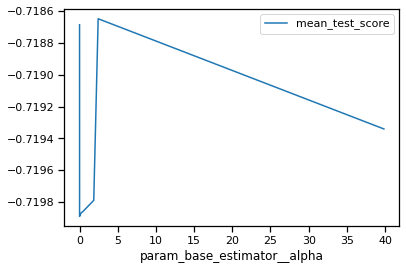

time: 588 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.param_base_estimator__class_weight = df.param_base_estimator__class_weight.astype(
    str
)
df.groupby("param_base_estimator__class_weight").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
param_base_estimator__class_weight,,,,,,,,,,,,,,,
None,2.205408,0.206213,0.159208,0.065652,-0.923560,-0.620641,-0.610488,-0.788285,-0.699937,-0.697546,-0.721192,-0.687747,-0.718674,0.093474,2.0
balanced,1.886553,0.212406,0.131261,0.046698,-0.925302,-0.624158,-0.612990,-0.788567,-0.700260,-0.699596,-0.721077,-0.686354,-0.719788,0.093157,7.0


time: 37 ms


In [13]:
def tune(alpha: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=CalibratedClassifierCV(
            base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
            method="isotonic",
            n_jobs=-1,
        ),
        param_distributions={"base_estimator__alpha": alpha},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_base_estimator__alpha", ascending=True)
        .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
    )
    df.plot(x="param_base_estimator__alpha", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_base_estimator__alpha", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 287 ms


Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7186185229694837
best params: {'base_estimator__alpha': 15.654978881412646}


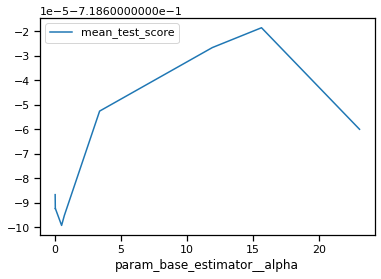

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7186571665387625
best params: {'base_estimator__alpha': 43.80956374686481}


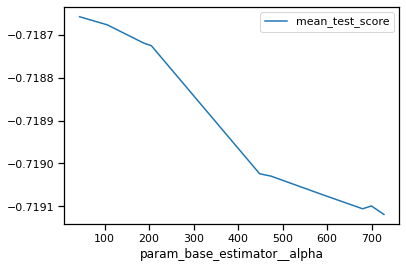

time: 54.7 s


In [14]:
df = tune(alpha=loguniform(1e-3, 1e3), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-3, 1e3), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7186061631465608
best params: {'base_estimator__alpha': 8.108874421334596}


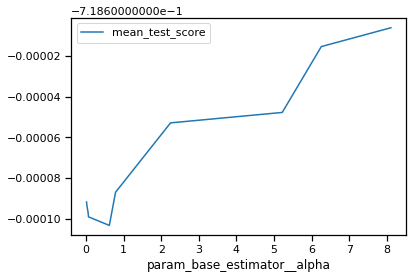

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.718621417402676
best params: {'base_estimator__alpha': 10.616287447626572}


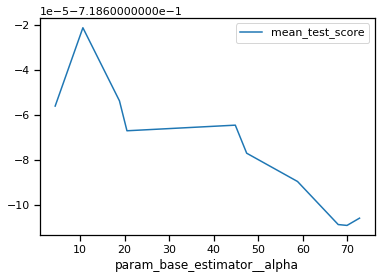

time: 1min


In [15]:
df = tune(alpha=loguniform(1e-2, 1e2), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 1e2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7186845258053953
best params: {'base_estimator__alpha': 1.0919470279424939}


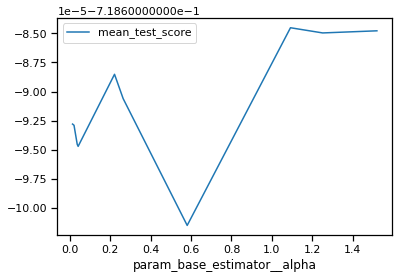

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7185946730668047
best params: {'base_estimator__alpha': 7.282401436844547}


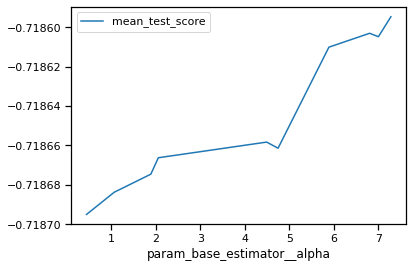

time: 1min


In [16]:
df = tune(alpha=loguniform(1e-2, 10), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7186688170111657
best params: {'base_estimator__alpha': 1.6986883737104392}


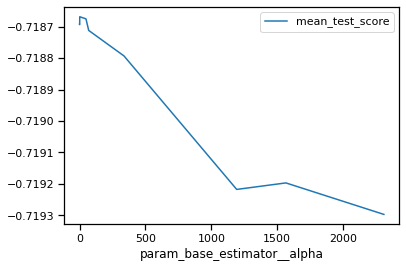

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7179680323695639
best params: {'base_estimator__alpha': 72724.11436844549}


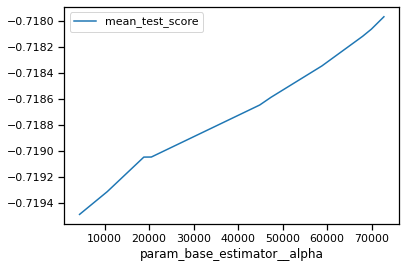

time: 1min 4s


In [17]:
df = tune(alpha=loguniform(0.1, 1e5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 1e5), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7175474062560752
best params: {'base_estimator__alpha': 183912.53501900678}


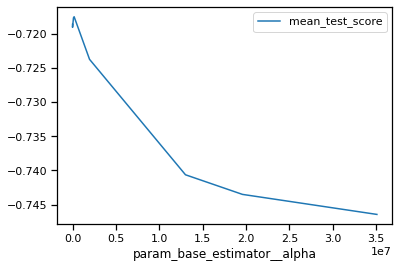

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7503866834756446
best params: {'base_estimator__alpha': 438085647.46864814}


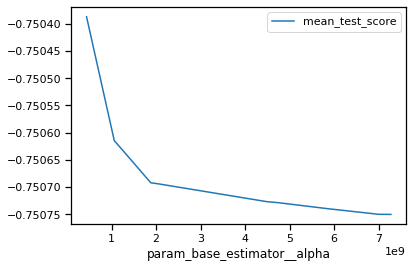

time: 47.2 s


In [18]:
df = tune(alpha=loguniform(10, 1e10), results_df=df, n_iter=10)
df = tune(alpha=uniform(10, 1e10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7172274563727061
best params: {'base_estimator__alpha': 249460.97626738678}


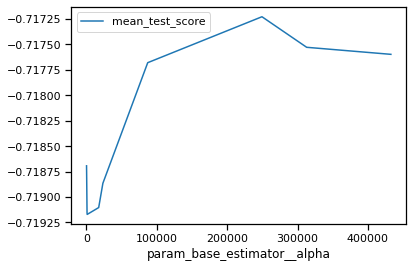

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7176068252876405
best params: {'base_estimator__alpha': 438185.63746864814}


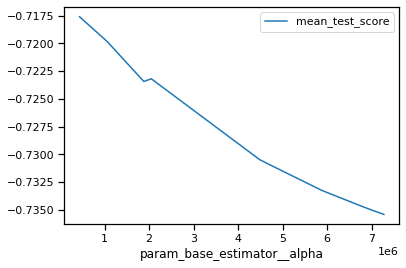

time: 46.1 s


In [19]:
df = tune(alpha=loguniform(100, 1e7), results_df=df, n_iter=10)
df = tune(alpha=uniform(100, 1e7), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7175133571255294
best params: {'base_estimator__alpha': 151956.9020693447}


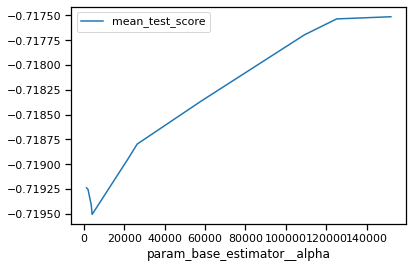

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7174296835170736
best params: {'base_estimator__alpha': 206018.9523942888}


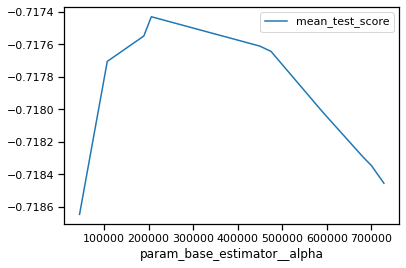

time: 43.7 s


In [20]:
df = tune(alpha=loguniform(1000, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1000, 1e6), results_df=df, n_iter=10)

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7172202184953222
best params: {'base_estimator__alpha': 249847.81642864086}


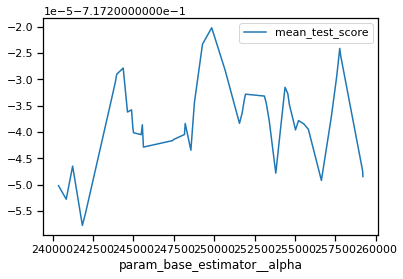

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7172219581321053
best params: {'base_estimator__alpha': 250047.9046873058}


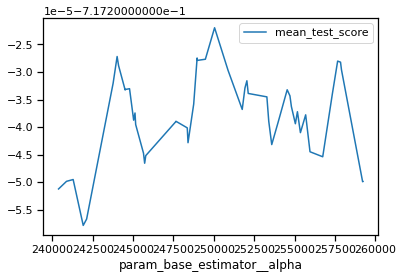

time: 2min 44s


In [29]:
df = tune(alpha=loguniform(240000, 260000), results_df=df, n_iter=50)
df = tune(alpha=uniform(240000, 20000), results_df=df, n_iter=50)

Fitting 8 folds for each of 25 candidates, totalling 200 fits
best score: -0.7186071110050669
best params: {'base_estimator__alpha': 13.450623105802409}


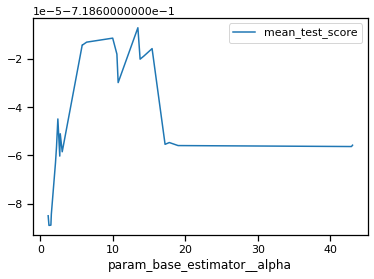

Fitting 8 folds for each of 25 candidates, totalling 200 fits
best score: -0.7186037394992616
best params: {'base_estimator__alpha': 10.219446041886794}


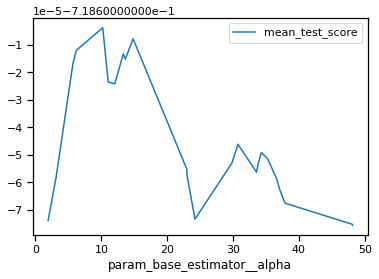

time: 1min 22s


In [30]:
df = tune(alpha=loguniform(1, 50), results_df=df, n_iter=25)
df = tune(alpha=uniform(1, 49), results_df=df, n_iter=25)

Fitting 8 folds for each of 21 candidates, totalling 168 fits
best score: -0.7172187364541067
best params: {'base_estimator__alpha': 249945.69701031796}


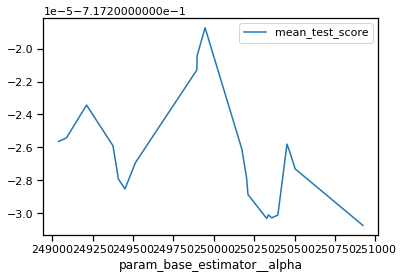

Fitting 8 folds for each of 21 candidates, totalling 168 fits
best score: -0.7172187427149941
best params: {'base_estimator__alpha': 249947.69140681645}


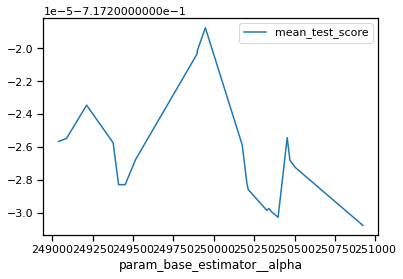

time: 1min 9s


In [39]:
df = tune(alpha=loguniform(249000, 251000), results_df=df, n_iter=21)
df = tune(alpha=uniform(249000, 2000), results_df=df, n_iter=21)

In [40]:
_ = gc_collect()

time: 151 ms


In [41]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/ridge_results.csv")

time: 4.99 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
8,249945.69701,-0.717219
8,249947.691407,-0.717219
16,249898.30263,-0.717220
9,249896.591649,-0.717220
16,249896.323575,-0.717220
9,249894.6133,-0.717221
5,249211.368034,-0.717223
5,249212.125749,-0.717223
3,249087.282418,-0.717225
6,250454.480287,-0.717225


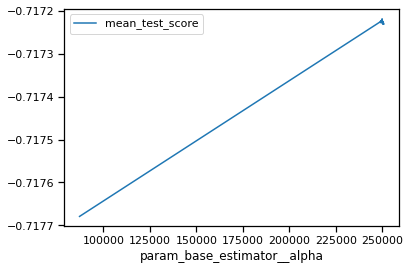

time: 232 ms


In [42]:
results_df = results_df.sort_values(by="param_base_estimator__alpha", ascending=True)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [43]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[
    results_df.mean_test_score == max_score
].param_base_estimator__alpha.iloc[0]

,param_base_estimator__alpha,mean_test_score
8,249945.69701,-0.717219


249945.69701031796

time: 18 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

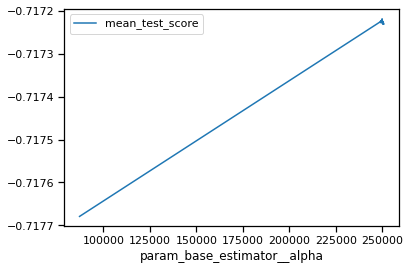

time: 232 ms


In [44]:
df = results_df.loc[results_df.param_base_estimator__alpha < 400000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

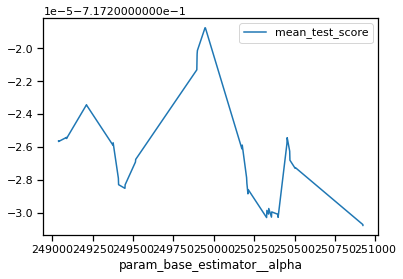

time: 204 ms


In [48]:
df = results_df.loc[results_df.param_base_estimator__alpha > 100000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

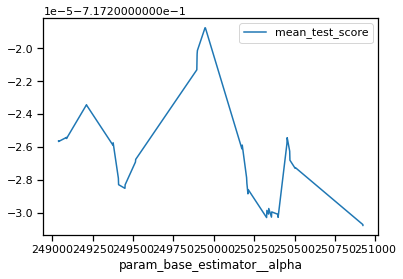

time: 192 ms


In [49]:
df = df.loc[df.param_base_estimator__alpha > 80000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [50]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 21786.6228351593 s
time: 145 ms


[^top](#Contents)